## Análisis Exploratorio de Datos (EDA) - Titanic (Kaggle)

### Dataset
https://www.kaggle.com/competitions/titanic/data

### Descripción
El hundimiento del Titanic es uno de los naufragios más infames de la historia.<br/>
El 15 de abril de 1912, durante su viaje inaugural, el RMS Titanic, considerado por muchos como "insumergible", se hundió tras chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos los pasajeros y la tripulación, lo que provocó la muerte de 1502 de los 2224 pasajeros y tripulantes.<br/>
Si bien la suerte influyó en la supervivencia, parece que algunos grupos de personas tuvieron más probabilidades de sobrevivir que otros.<br/>
Este trabajo busca identificar estos grupos y determinar la probabilidad de supervivencia de cada pasajero en base al grupo al que pertenezca.

### Propósito del EDA
Analizar e investigar el conjunto de datos y resumir sus características principales.<br/>
Permite analizar los datos antes de hacer suposiciones. Puede ayudar a identificar errores obvios, así como a comprender mejor los patrones dentro de los datos, detectar valores atípicos o eventos anómalos y encontrar relaciones interesantes entre las variables.<br/>


### Objetivos puntuales:
1. Analizar la calidad de los datos, detectar valores faltantes y posibles outliers.
2. Realizar visualizaciones para comprender la distribución de las variables.
3. Realizar gráficos comparativos (por ejemplo, supervivencia según clase, sexo y edad).
4. Analizar si algunas características influyen más que otras en la supervivencia.
5. Determinar si el dataset está balanceado respecto a la variable objetivo (Survived).

Importación de librería y configuraciones del sistema

In [219]:
#Importación de librerías

#%pip install pandas numpy matplotlib seaborn scipy   

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
sns.set_theme(style="darkgrid")

Funciones auxiliares

In [220]:
# Funciones auxiliares de traducción de nombres de columnas
def translate(col):
    """Traduce un nombre de columna al español."""
    return {
        "PassengerId": "ID Pasajero",
        "Survived": "Supervivencia",
        "Pclass": "Clase",
        "Name": "Nombre",
        "Sex": "Sexo",
        "Age": "Edad",
        "SibSp": "Hermanos/Esposos",
        "Parch": "Padres/Hijos",
        "Ticket": "Ticket",
        "Fare": "Tarifa",
        "Cabin": "Cabina",
        "Embarked": "Embarque",
        "FamilySize": "Tamaño Familia",
        "IsAlone": "Viaja Solo",
        "Embarked_P": "Embarque P",
        "Embarked_Q": "Embarque Q",
        "Embarked_S": "Embarque S",
        "Pclass_1": "Clase 1",
        "Pclass_2": "Clase 2",
        "Pclass_3": "Clase 3",
    }.get(col, col)

    

def translate_list(cols):
    return {col: translate(col) for col in cols}


In [221]:
# Funciones utilizadas en datos faltantes

# Calculo de datos faltantes
def missing_values(df: pd.DataFrame) -> pd.DataFrame:

    return df.isna().sum().sort_values(ascending=False)


# Resumen de datos faltantes
def summarize_missing(df: pd.DataFrame) -> pd.DataFrame:

    missing_values = df.isnull().sum()
    missing_percentage = missing_values.div(len(df)).mul(100)

    summary = pd.DataFrame(
        {
            "Faltantes": missing_values,
            "Porcentaje": missing_percentage,
        }
    ).sort_values("Porcentaje", ascending=False)

    return summary[summary["Faltantes"] > 0]

# Visualización de los datos
def plot_missing_values(df, title="Cantidad de valores faltantes por columna"):
    plt.figure(figsize=(8, 6))

    # Aplicar la traducción a cada nombre de columna
    translated_labels = [translate(col) for col in df.index]

    ax = sns.barplot(
        x=translated_labels,
        y=df.values,
    )
    
    plt.title(title)
    plt.ylabel("Cantidad de valores nulos")
    plt.xlabel("Columnas")
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Etiquetas de valor sobre cada barra
    for container in ax.containers:
        ax.bar_label(
            container,
            padding=3,
            fontsize=10
        )

    plt.show()


In [222]:
# Funciones auxiliares para gráficas de variables categóricas 

def compute_counts(frame, column):
    counts = (
        frame[column]
        .value_counts()
        .sort_index()
        .rename_axis(column)
        .reset_index(name="Cantidad")
    )
    return counts

def plot_counts(counts, column):
    plt.figure(figsize=(6, 6))
    ax = sns.barplot(data=counts, x=column, y="Cantidad", width=0.5)
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=10)
    plt.title(f"Distribución de {translate(column)}")
    plt.xlabel(translate(column))
    plt.ylabel("Cantidad")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_cat_columns(frame, columns):
    for column in columns:
        counts = compute_counts(frame, column)
        plot_counts(counts, column)   



In [223]:
# Funciones auxiliares para el cálculo y gráficos de supervivencia por categorías

def survival_rate_by(column_name):
    """
    Devuelve la tasa de supervivencia media por categoría de la columna especificada.
    """
    return df.groupby(column_name, observed=False)["Survived"].mean().sort_values(ascending=False)

def survival_count_by(column_name):
    """
    Devuelve la supervivencia por categoría de la columna especificada.
    """
    return df.groupby(column_name, observed=False)["Survived"].sort_values(ascending=False)

In [224]:
# Funciones auxiliares para gráficos de supervivencia por categorías
def plot_survival_count(
    data,
    x_column: str,
    figsize=(6, 4),
    x_label: str | None = None,
    title: str | None = None,
) -> None:
    x_label = x_label or x_column
    if title is None:
        title = f"Supervivencia según {x_label.lower()} (recuento)"

    fig, ax = plt.subplots(figsize=figsize)

    sns.countplot(data=data, x=x_column, hue="Survived", ax=ax, width=0.5)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Cantidad")

    ax.legend(title="Supervivió", labels=["No", "Sí"])

    # Etiquetas numéricas sobre cada barra
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=10)

    fig.tight_layout()
    plt.show()

Carga de datos

In [225]:
# Carga del dataset de entrenamiento
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1. Análisis de la calidad de los datos
* Dimensiones del dataset
* Tipos de datos
* Estadísticos descriptivos básicos
* Valores faltantes

#### Dimensiones

In [226]:
# Dimensiones del dataset
print("Dimensiones del conjunto de datos (filas, columnas):", df.shape)

Dimensiones del conjunto de datos (filas, columnas): (891, 12)


#### Tipos de datos

In [227]:
# Información general (tipos de datos, nulos)
print("\nInformación del DataFrame:\n")

df.info()


Información del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Valores distintos para cada columna

In [228]:
df.nunique().to_frame("Valores distintos").assign(dtype=df.dtypes)

,Valores distintos,dtype
PassengerId,891,int64
Survived,2,int64
Pclass,3,int64
Name,891,object
Sex,2,object
Age,88,float64
SibSp,7,int64
Parch,7,int64
Ticket,681,object
Fare,248,float64


Hasta acá se puede observar que, el id del pasajero y el nombre tienen datos distintos lo que da la pauta de que no hay filas repetidas.<br/>
Respecto a los tipos de datos utilizados se puede observar que no en todos los casos se utilizan los tipos correctos:
* *Survived*: Es un booleano
* *Pclass*: Es categórico, sólo tiene 3 valores posibles
* *Sex*: Es booleano
* *Embarked*: Es categórico, sólo tiene 3 valores posibles

#### Estadísticos descriptivos básicos


In [229]:
# Estadísticas descriptivas de variables numéricas

columns_num = ["Age", "Fare", "SibSp", "Parch"]

print("\nEstadísticas descriptivas (numéricas):")

df[columns_num].rename(columns=translate_list(columns_num)).describe()



Estadísticas descriptivas (numéricas):


,Edad,Tarifa,Hermanos/Esposos,Padres/Hijos
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


Se puede observar que para:
* **Edad**: 
    * Faltan valores. 
    * El rango intercuartiles (3º cuartil - 1º cuartil) es de 18 años
    * A pesar de haber pasajeros de 80 años el 75% tenía 38 o menos. 

* **Tarifa**
    * Los datos están completos
    * A pesar de haber pasajeros de 80 años el 75% tenía 38 o menos. 
    El 75% de los pasajetos tenía hasta 38 años
* Hay valores extremos atípicos en el último cuartil de **Hermanos/Esposos** y **Padres/Hijos**

### Visualización - Variables numéricas

A fin de mejorar la complención sobre la distribución de los datos se realizan los siguinente gráficos 

Histogramas de variables numéricas

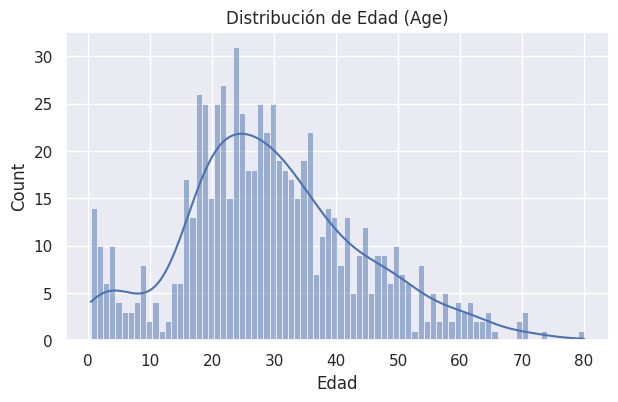

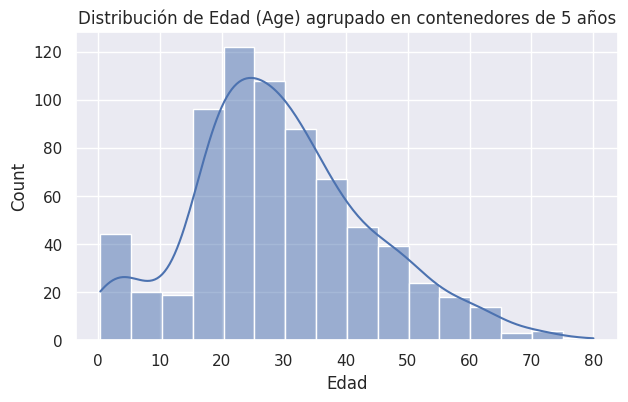

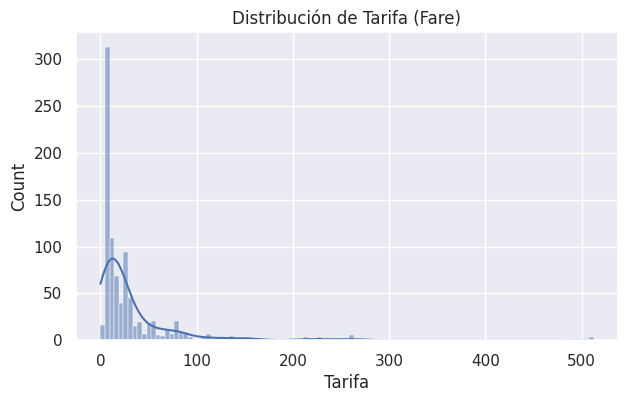

In [230]:
# Histograma de Age
plt.figure(figsize=(7,4))
sns.histplot(df["Age"].dropna(), kde=True, bins=80)
plt.title("Distribución de Edad (Age)")
plt.xlabel("Edad")
plt.show()

# Histograma de Age en menos contenedores
plt.figure(figsize=(7,4))
sns.histplot(df["Age"].dropna(), kde=True, bins=16)
plt.title("Distribución de Edad (Age) agrupado en contenedores de 5 años")
plt.xlabel("Edad")
plt.show()

# Histogramas de Fare
plt.figure(figsize=(7,4))
sns.histplot(df["Fare"], kde=True, bins='fd')
plt.title("Distribución de Tarifa (Fare)")
plt.xlabel("Tarifa")
plt.show()

Se observa que los datos de la Edad tienen una forma normal, ligeramente sesgada.<br/>
La tarifa se encuentra completamente sesgada.

## Variables categóricas (discretas)

Gráficos de barras varticales

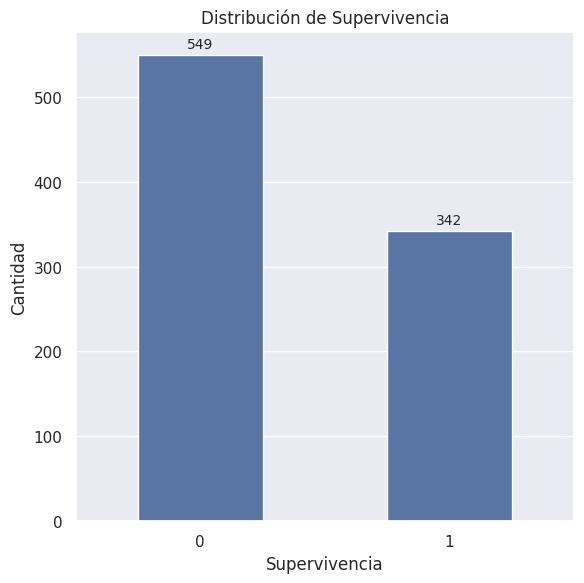

In [231]:
plot_cat_columns(df, ["Survived"])

Se observa que fueron más los fallecidos que los suprevivientes. **El dataset se encuentra desbalanceado**.

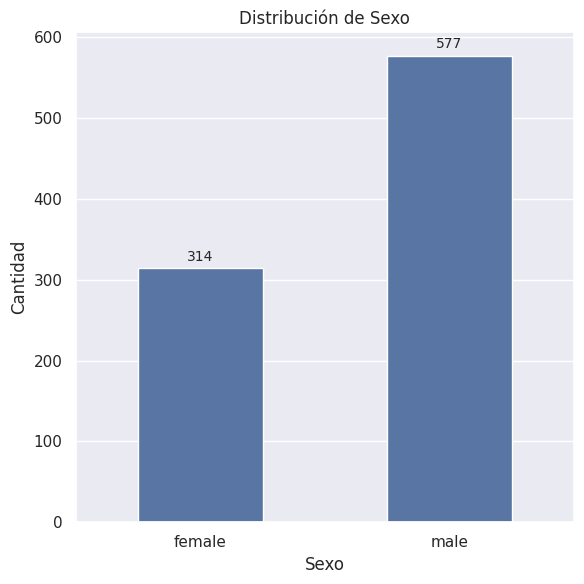

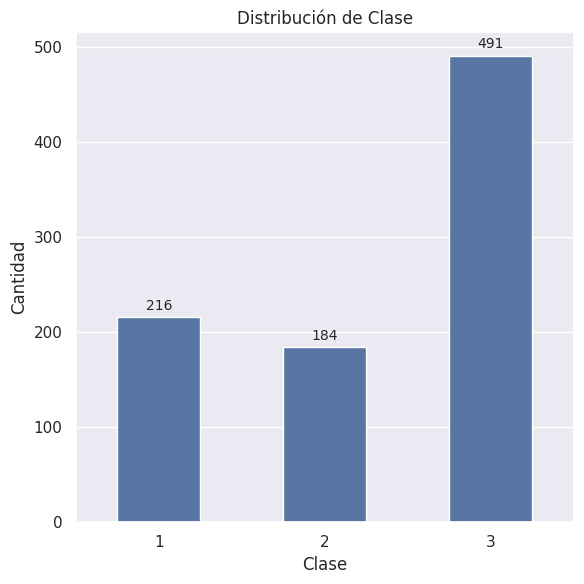

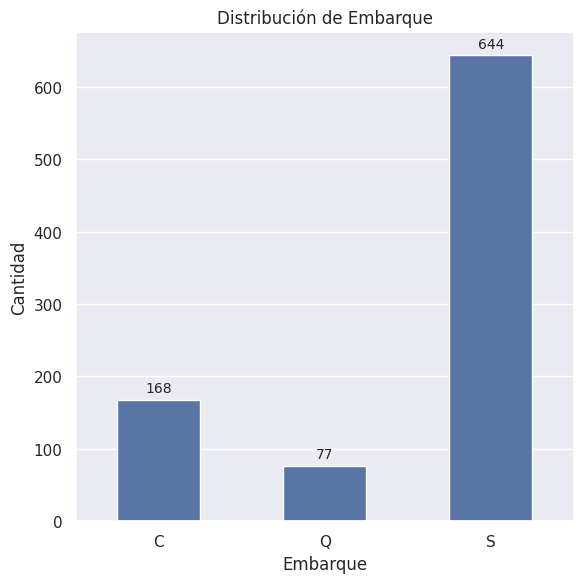

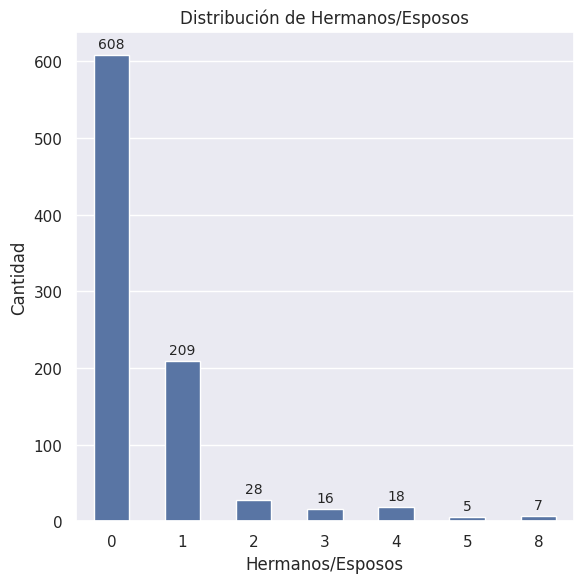

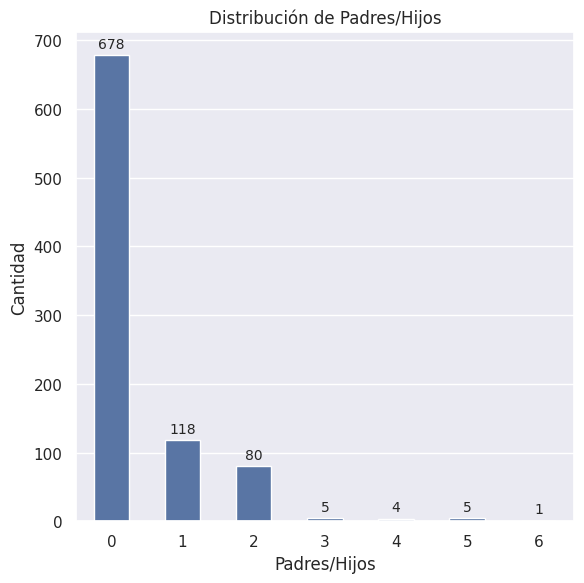

In [232]:
columnas_categoricas = ["Sex", "Pclass", "Embarked", "SibSp", "Parch"]
plot_cat_columns(df, columnas_categoricas)


#### Datos faltantes

Datos faltantes en el dataset

          Faltantes  Porcentaje
Cabin           687   77.104377
Age             177   19.865320
Embarked          2    0.224467


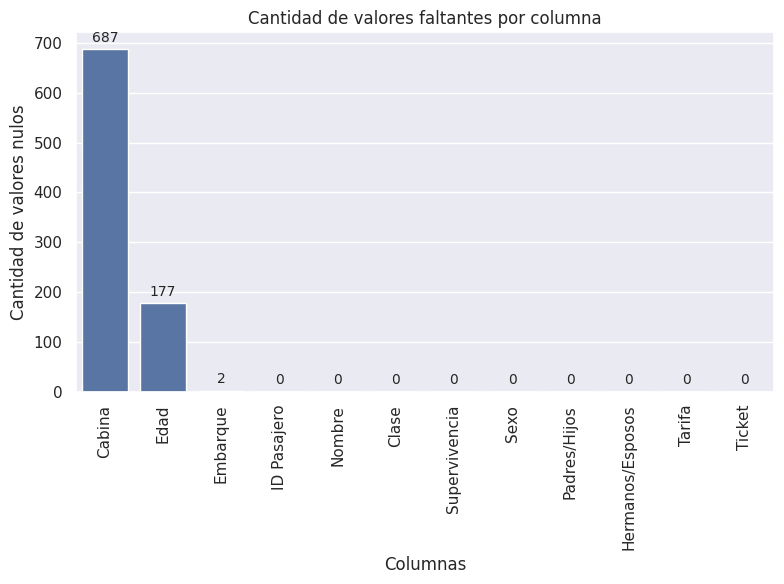

In [233]:
# Resumen de datos faltantes por columna
sumarized_missing_data = summarize_missing(df)

print("Datos faltantes en el dataset\n")
print(sumarized_missing_data)

# Gráfico de faltantes por columna
missing_data = missing_values(df)

plot_missing_values(missing_data)

Faltan el 77.10% de los datos de la cabina, el 19.87% de los de edad y el 0.22% del puerto de embarque. Para el resto de las columnas los datos están completos.

#### Detección de Outliers

In [234]:
# --- Función para graficar boxplots de columnas numéricas ---
def plot_boxplots(df, columns):
    """
    Genera boxplots para las columnas especificadas.
    
    Parámetros:
        df (pd.DataFrame): dataset
        columns (list): lista de nombres de columnas numéricas
    """
    num_cols = len(columns)
    filas = (num_cols + 1) // 2  # para organizar en 2 columnas

    fig, axes = plt.subplots(filas, 2, figsize=(12, 4 * filas))
    axes = axes.ravel()  # convertir matriz de ejes a lista plana

    for idx, col in enumerate(columns):
        sns.boxplot(
            data=df,
            y=df[col],      # Usamos y para poder etiquetar correctamente
            ax=axes[idx],
            width=0.25
        )
        axes[idx].set_title(f"Diagrama de caja de {translate(col)}")
        axes[idx].set_xlabel("")  # limpiamos eje X
        axes[idx].set_ylabel(translate(col))

    # Ocultar ejes sobrantes si columns_num no es múltiplo de 4
    for j in range(idx + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


In [235]:
columns_num = ["Age", "Fare", "SibSp", "Parch"]
df[columns_num].rename(columns=translate_list(columns_num)).describe()

,Edad,Tarifa,Hermanos/Esposos,Padres/Hijos
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


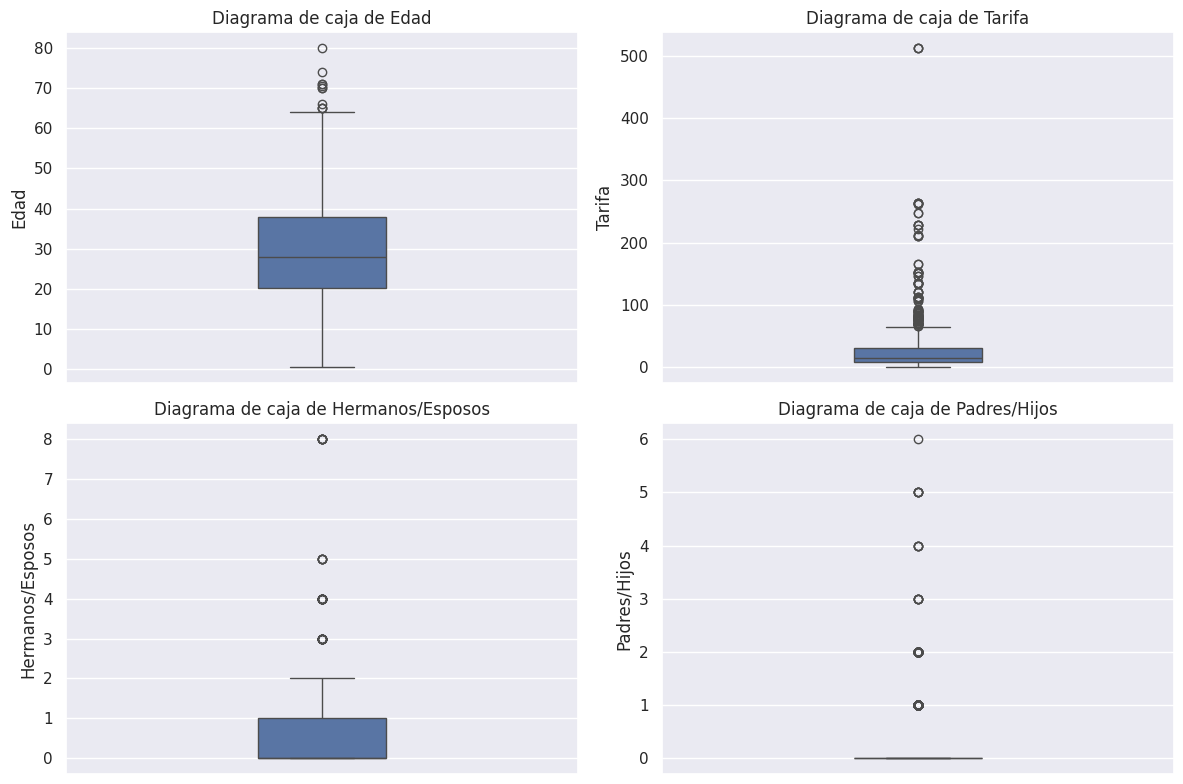

In [236]:
# Describe con nombres traducidos
plot_boxplots(df, columns_num)

Detección de outliers utilizando z-score

In [237]:
#Reporte de outliers utilizando z-score

num_cols = ["Age", "Fare", "SibSp", "Parch"]

def detect_outliers_zscore(df, column, threshold=3):

    series = df[column]
    valid_values = series.dropna()

    z_scores = np.abs(stats.zscore(valid_values))
    outliers = valid_values[z_scores > threshold]

    return outliers


def print_outliers_report(df, columns, threshold=3):

    print(f"\nReporte de outliers (Z-score > {threshold})\n")

    for col in columns:
        outliers = detect_outliers_zscore(df, col, threshold)
        print(f" {col}: {len(outliers)} outliers")


# Ejecución
threshold = 3
print_outliers_report(df, num_cols, threshold)


Reporte de outliers (Z-score > 3)

 Age: 2 outliers
 Fare: 20 outliers
 SibSp: 30 outliers
 Parch: 15 outliers


Para la deteccion de outliers se utilizaron 2 técnicas:
* **Diagramas de caja**: Representan la distribución de los datos, los valores atípicos y la mediana. El cuadro dentro del gráfico muestra dónde se ubican aproximadamente el 50 % de los puntos de datos. Este muestra outliers el cuartil superior para todas las variables numéricas analizadas.
* **z-score**: A fin de ponerle un número exacto de outliers de utilizó el indicador z-score. Este método calcula la puntuación Z para cada punto de datos, que mide cuántas desviaciones estándar se aleja de la media. Dado que dentro de los 3 desvíos estándar debería encontrarse el 99.7% de los datos, cualquier punto de dato con una puntuación Z mayor que 3 o menor que -3 se considera un valor atípico.

#### Análisis de supervivencia

Recuento de Sobrevivientes:
Survived
0    549
1    342
Name: count, dtype: int64

Proporciones de Sobrevivientes:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


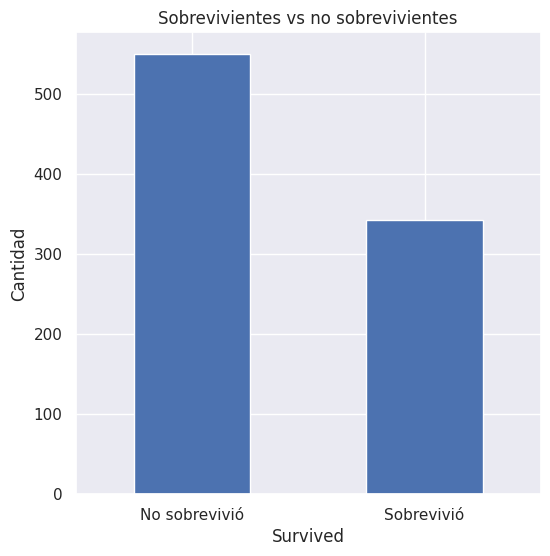

In [238]:
#Supervivencia global
surv_counts = df["Survived"].value_counts()
surv_props = df["Survived"].value_counts(normalize=True)

print("Recuento de Sobrevivientes:")
print(surv_counts)
print("\nProporciones de Sobrevivientes:")
print(surv_props)

plt.figure(figsize=(6,6))
surv_counts.plot(kind="bar")
plt.title("Sobrevivientes vs no sobrevivientes")
plt.xticks([0, 1], ["No sobrevivió", "Sobrevivió"], rotation=0)
plt.ylabel("Cantidad")
plt.show()


Se observa que fallecieron 549 pasajeros, lo que represente el 61.62% y sobrevivieron 342 que es un 38.38%.<br/>
**El dataset se encuentra desbalanceado**.

#### Análisis bivariado

Acá se analiza la relación entre dos variables. En todos los casos de compará la supervivencia contra las demás variables


Tasa de supervivencia por Sexo:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 



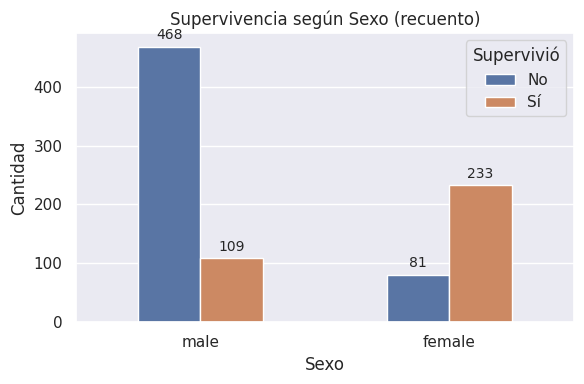


Tasa de supervivencia por Clase:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 



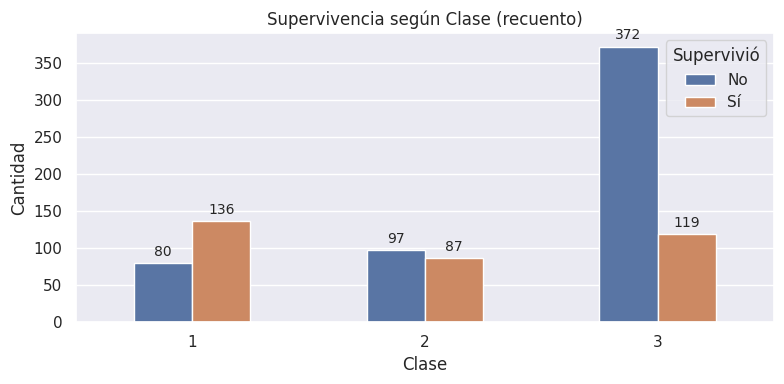


Tasa de supervivencia por Embarque:
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64 



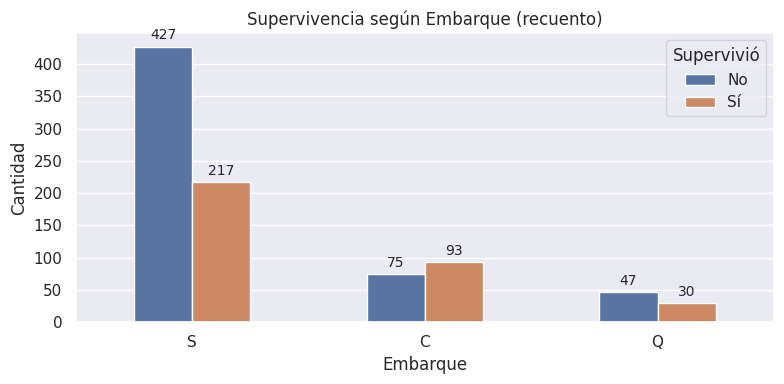


Tasa de supervivencia por Hermanos/Esposos:
SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64 



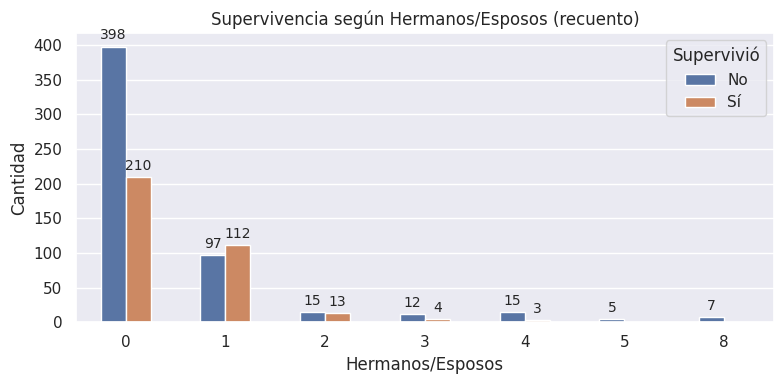


Tasa de supervivencia por Padres/Hijos:
Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
4    0.000000
6    0.000000
Name: Survived, dtype: float64 



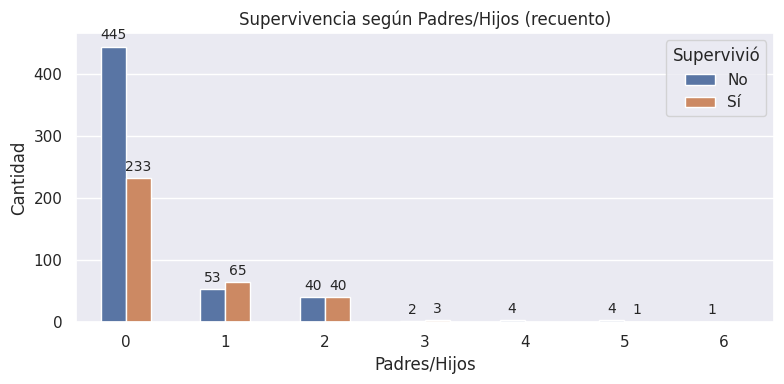

In [239]:
# Arreglo con las columnas a evaluar y el tamaño de figura deseado
COLUMNS_TO_ANALYZE = [
    ("Sex",     (6, 4)),
    ("Pclass",  (8, 4)),
    ("Embarked",(8, 4)),
    ("SibSp",   (8, 4)),
    ("Parch",   (8, 4)),
]


def analyze_survival_by_columns(df, columns_with_figsize):
    """
    Imprime la tasa de supervivencia y grafica el recuento
    para cada columna categórica indicada.
    """
    for col_name, figsize in columns_with_figsize:
        col_label = translate(col_name)

        # 1) Texto en consola
        print(f"\nTasa de supervivencia por {col_label}:")
        print(survival_rate_by(col_name), "\n")

        # 2) Gráfico de barras
        plot_survival_count(
            data=df,
            x_column=col_name,
            figsize=figsize,
            x_label=col_label,
            title=f"Supervivencia según {col_label} (recuento)"
        )


# Llamada única desde tu notebook/script
analyze_survival_by_columns(df, COLUMNS_TO_ANALYZE)


In [240]:
# Crear grupos de edad
bins = [0, 12, 18, 30, 50, 80]
labels = ["0-12", "13-18", "19-30", "31-50", "51-80"]
df["AgeBin"] = pd.cut(df["Age"], bins=bins, labels=labels, include_lowest=True)

Tasa de supervivencia por rango de edad:
AgeBin
0-12     0.579710
13-18    0.428571
31-50    0.423237
19-30    0.355556
51-80    0.343750
Name: Survived, dtype: float64


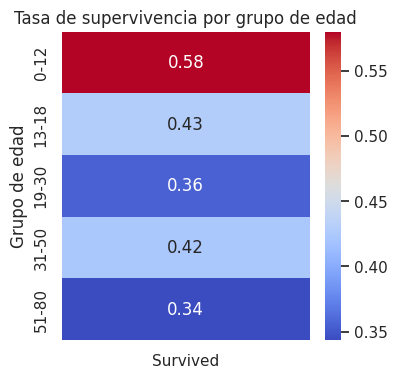

In [241]:
# Crear tabla pivote con la tasa de supervivencia por AgeBin

print("Tasa de supervivencia por rango de edad:")
print(survival_rate_by("AgeBin"))

age_survival = df.pivot_table(
    values="Survived",
    index="AgeBin",
    aggfunc="mean",
    observed=False 
)

plt.figure(figsize=(4,4))
sns.heatmap(
    age_survival,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Tasa de supervivencia por grupo de edad")
plt.xlabel("")
plt.ylabel("Grupo de edad")
plt.show()



#### Análisis multivariado

Se analizan la relación entre 3 variables.

**Supervivencia por clase y sexo**

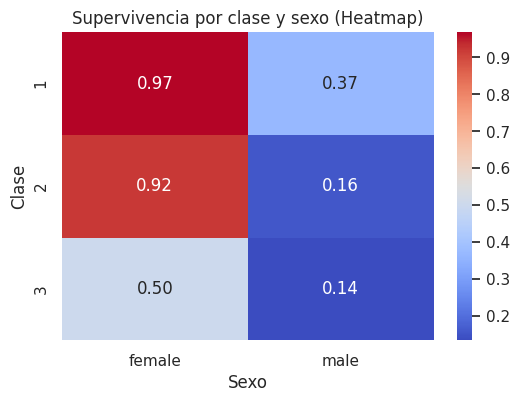

In [242]:
pivot = df.pivot_table(
    values="Survived",
    index="Pclass",
    columns="Sex",
    aggfunc="mean"
)

plt.figure(figsize=(6,4))
sns.heatmap(
    pivot, annot=True, cmap="coolwarm", fmt=".2f"
)

plt.title("Supervivencia por clase y sexo (Heatmap)")
plt.xlabel("Sexo")
plt.ylabel("Clase")
plt.show()

Se observa que es altamente probable sobrevivir siendo una mujer de clase alta y muy poco probable si se es un hombre de clase baja. Además que las mujeres las mujeres de cualquier da las clases tenían mayores probabilidades que los hombres.

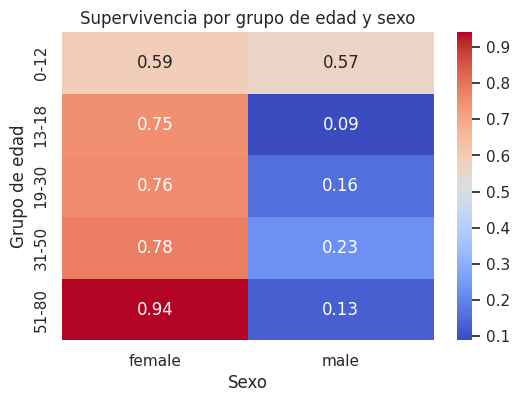

In [243]:
age_sex = df.pivot_table(
    values="Survived",
    index="AgeBin",
    columns="Sex",
    aggfunc="mean",
    observed=False 

)

plt.figure(figsize=(6,4))
sns.heatmap(
    age_sex,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Supervivencia por grupo de edad y sexo")
plt.xlabel("Sexo")
plt.ylabel("Grupo de edad")
plt.show()


En este mapa de calor se puede ver que en caso de las mujeres a mayor edad más probabilidades de salvarse y en el caso de los hombres el porcentaje más alto estaba en los niños.

### Matriz de correlación multivariada

Se evalua el nivel de correlación entre todas las variables numéricas

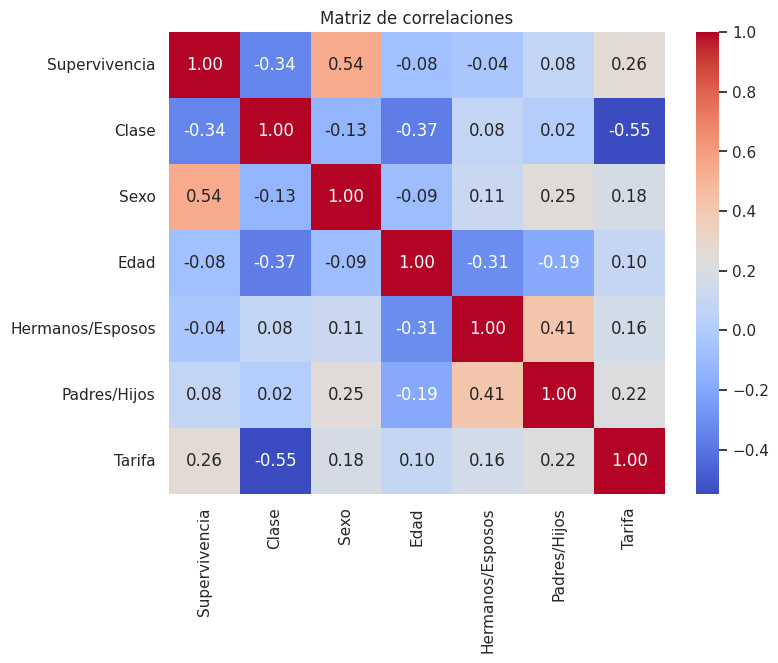

In [ ]:
# Copia del DataFrame para codificar variables
df_corr = df.copy()

# Codificar Sex como variable numérica
df_corr["Sex"] = df_corr["Sex"].map({"male": 0, "female": 1})

# Seleccionamos algunas columnas numéricas relevantes
corr_cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
corr_matrix = df_corr[corr_cols].corr()

corr_matrix.index = [translate(col) for col in corr_matrix.index]
corr_matrix.columns = [translate(col) for col in corr_matrix.columns]

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaciones")
plt.show()

**Conclusiones de la matriz de correlación:**
* Supervivencia: 
    * El sexo masculino se codificó como 0 y el femenino como 1, es por esto que en la matriz se ve que la supervivencia se correlaciona con el sexo. Las mujeres tenían más probabilidades que los hombres.
    * Al tomar las clases como 1, 2 y 3, la clase alta tiene un número bajo y la clase baja un número alto. Esto da como resultado que la correlación sea negativa, una clase 3 tiene menos probabilidades de sobrevivir que una clase 1. 
    * Hay una leve correlación positiva respecto a la tarifa pagada y la probabilidad de sobrevivir, esto confirma la correlación vista en la clase en la quie viajaba el pasajero. 
    * Para el resto de variables la correlación es prácticamente nula.
* Clase:
    * Por lo explicado anteriormente se puede ser una obvia correlación negativa entre clase y tarifa, un parajero de clase 1 pagó más que uno de clase 3.
    * Con relación a la edad también hay correlación negativa, una clase 1 tiene más edad que una clase 3.
    * Por estár codificado el sexo masculino se como 0 y el femenino como 1 se puede ver que se da una leve correlación negativa, a mayor valor en la clase más probable que sea hombre.
* Sexo:
    * La mujeres era más probable que viajen con familiares que los hombres.
* Edad :
    * A mayor edad menos probable que viajen con hermanos o esposos y levemente menos probable que viajen con padres o hijos.
* Hermanos/esposos:
    * Si viajaban con hermanos o esposos era más probable que viajaran con padres o hijos.
    * Hay una leve correlación positiva con la tarifa.
* Padres/hijos:
    * Al igual que en el caso anterior, se puede ver que si viajaban con padres o hijos era más problable que hayan pagado una tarifa más alta.